## DATA MINING FINAL PROJECT NOTEBOOK (Pt 2)

As loading all the code together in one jupyter notebook would be too heavy  for the group to upload it aswell as for the teachers to run it, if needed, the code is divided into 3 different jupyters, as follows:

- Pt1: Preprocessing pt1
- Pt2: Preprocessing pt2
- Pt3: Clustering

* [3. Redundancy and Irrelevance](#3.)
    * [3.1. Donors metric](#3.1.)
    * [3.2. Donors categorical](#3.2.)
    * [3.3. Info metric](#3.3.)
    * [3.4. Info categorical ](#3.4.)
    
    
* [4. Final Adjustments](#4.)

In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from math import ceil
from datetime import datetime
from sklearn.impute import KNNImputer
import sklearn.preprocessing as prep
import statsmodels.api as statsm
import matplotlib.colors as colors
import scipy.stats as stats 
import sklearn.impute as imp
import matplotlib.gridspec as gspec
import matplotlib.cm as cm
import feature_engine.missing_data_imputers as mdi
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from pandas_profiling import ProfileReport
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
import statsmodels as sm
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')

sns.set()

In [2]:
info_metric = pd.read_csv(r'D:\OneDrive - NOVAIMS\NOVA IMS - Master\1st Year\1st Semester\Data Mining\Group Project\info_metric_pt1.csv')
info_categorical = pd.read_csv(r'D:\OneDrive - NOVAIMS\NOVA IMS - Master\1st Year\1st Semester\Data Mining\Group Project\info_categorical_pt1.csv')
donors_metric = pd.read_csv(r'D:\OneDrive - NOVAIMS\NOVA IMS - Master\1st Year\1st Semester\Data Mining\Group Project\donors_metric_pt1.csv')
donors_categorical = pd.read_csv(r'D:\OneDrive - NOVAIMS\NOVA IMS - Master\1st Year\1st Semester\Data Mining\Group Project\donors_categorical_pt1.csv')

In [3]:
info_metric = info_metric.set_index('CONTROLN')
donors_metric = donors_metric.set_index('CONTROLN')
info_categorical = info_categorical.set_index('CONTROLN')
donors_categorical = donors_categorical.set_index('CONTROLN')

In [4]:
donors = pd.concat([donors_metric,donors_categorical], axis = 1)
info = pd.concat([info_metric,info_categorical], axis = 1)

In [5]:
def sizes():
    print('Info:',info.shape[0], 'rows and', info.shape[1],'comlumns')
    print('Donors:',donors.shape[0], 'rows and', donors.shape[1],'comlumns')
    print('IMetric:',info_metric.shape[0], 'rows and', info_metric.shape[1],'comlumns')
    print('DMetric:',donors_metric.shape[0], 'rows and', donors_metric.shape[1],'comlumns')
    print('ICategorical:',info_categorical.shape[0], 'rows and', info_categorical.shape[1],'comlumns')
    print('DCategorical:',donors_categorical.shape[0], 'rows and', donors_categorical.shape[1],'comlumns')

sizes()

Info: 95412 rows and 320 comlumns
Donors: 95412 rows and 76 comlumns
IMetric: 94861 rows and 269 comlumns
DMetric: 95412 rows and 12 comlumns
ICategorical: 95412 rows and 51 comlumns
DCategorical: 95412 rows and 64 comlumns


<hr>
<a class="anchor" id="3.">
    
#  3. Redudancy and Irrelevance
    
</a>

<hr>
<a class="anchor" id="3.1">
    
#  3.1. Donors Metrics
    
</a> 

In [6]:
test = donors_metric.copy()

In [7]:
sizes()

Info: 95412 rows and 320 comlumns
Donors: 95412 rows and 76 comlumns
IMetric: 94861 rows and 269 comlumns
DMetric: 95412 rows and 12 comlumns
ICategorical: 95412 rows and 51 comlumns
DCategorical: 95412 rows and 64 comlumns


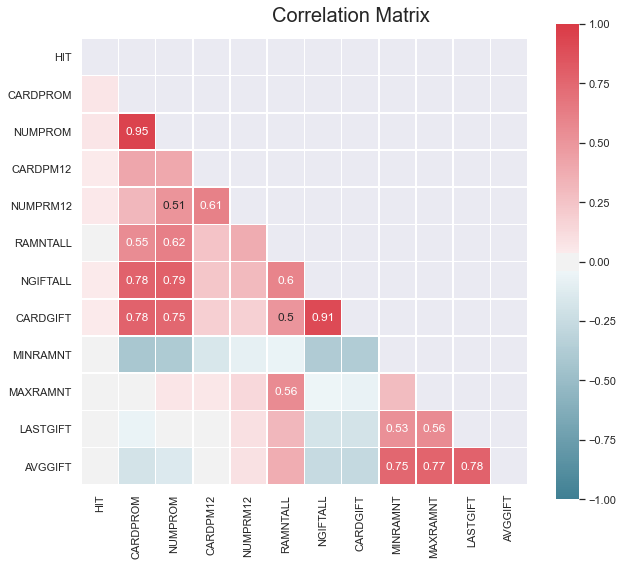

In [8]:
#CORRELATION MATRIX

fig = plt.figure(figsize=(10, 8))

corr = np.round(test.corr(method="pearson"), decimals=2)

mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) 
upper = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(data=corr, mask = upper, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [9]:
#GETTING FEATURES THAT HAVE VERY HIGH CORRELATIONS
corr_matrix = test.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

In [10]:
to_drop

['NUMPROM', 'CARDGIFT']

In [11]:
max_values = upper.describe().loc[['max']]
max_values.min().sort_values(ascending = True).head()

CARDPROM    0.070476
CARDPM12    0.406926
MINRAMNT    0.415771
MAXRAMNT    0.557428
LASTGIFT    0.562620
dtype: float64

In [12]:
donors_metric.var().sort_values(ascending = True).head()

CARDPM12     1.487876
CARDGIFT    20.490566
NUMPRM12    20.648240
NGIFTALL    73.176759
CARDPROM    73.681522
dtype: float64

## Analysis

- **CARDPROM** and **NUMPROM** are extremely correlated, and **CARDPROM** seems to be the least important one. 
- **CardGift** and **Ngiftall** are also very alike, and cardgift is the least important/ more specific of the two, we extract more information by keeping the more general variables.
- With the same logic we decided to substitute **Min** and **Max** RAMNT by just the **AVGGIFT** 
- We decided to remove **LASTGIFT** for being too related with **AVGGIFT**, once lastgift was the only gift for many people.
- **CARDPM12** has 0,61 of correlation with the **NUMPRM12**, and the number of promotions seems more relevant. Also, it seems to have almost no correlation with any other feature
- **NUMPROM** was also removed for having high correlations.


In [13]:
donors.drop(['CARDPROM','CARDGIFT','MINRAMNT','MAXRAMNT','CARDPM12','LASTGIFT','NUMPROM'], axis=1, inplace=True)
donors_metric.drop(['CARDPROM','CARDGIFT','MINRAMNT','MAXRAMNT','CARDPM12','LASTGIFT','NUMPROM'], axis=1, inplace=True)

In [14]:
print('Dropped', 18 - donors_metric.shape[1], 'features' )

Dropped 13 features


In [15]:
sizes()

Info: 95412 rows and 320 comlumns
Donors: 95412 rows and 69 comlumns
IMetric: 94861 rows and 269 comlumns
DMetric: 95412 rows and 5 comlumns
ICategorical: 95412 rows and 51 comlumns
DCategorical: 95412 rows and 64 comlumns


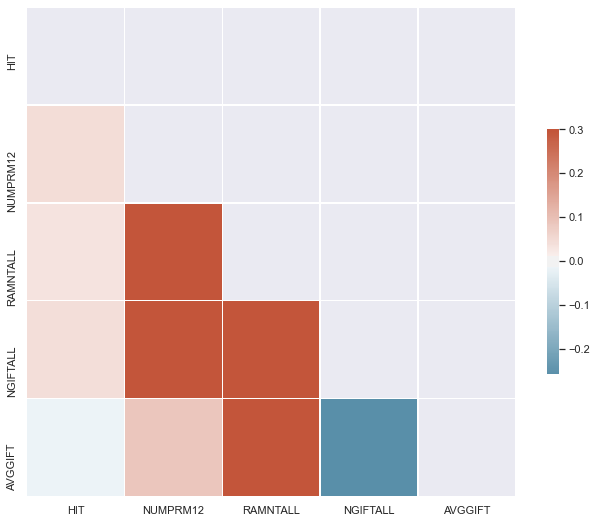

In [16]:
# CORRELATION MATRIX
corr = donors_metric.corr()
upper = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=upper, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<hr>
<a class="anchor" id="3.2.">
    
#  3.2. Donors categorical
    
</a> 

Based on:
- https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
- https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix

In [17]:
sizes()

Info: 95412 rows and 320 comlumns
Donors: 95412 rows and 69 comlumns
IMetric: 94861 rows and 269 comlumns
DMetric: 95412 rows and 5 comlumns
ICategorical: 95412 rows and 51 comlumns
DCategorical: 95412 rows and 64 comlumns


In [18]:
df_ = donors_categorical.copy()

In [19]:
# df_ = df_.drop(columns = ['RFA_2','ADATE_18'])

In [20]:
df_.columns

Index(['ODATEDW', 'OSOURCE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG',
       'RECSWEEP', 'MDMAUD', 'DATASRCE', 'SOLP3', 'SOLIH', 'MAJOR', 'GEOCODE',
       'PCOWNERS', 'PEPSTRFL', 'POP901', 'POP902', 'POP903', 'POP90C1',
       'POP90C2', 'POP90C3', 'POP90C4', 'POP90C5', 'ETH1', 'ETH2', 'ETH3',
       'ETH4', 'ETH5', 'ETH6', 'ETH7', 'ETH8', 'ETH9', 'ETH10', 'ETH11',
       'ETH12', 'ETH13', 'ETH14', 'ETH15', 'ETH16', 'AGE901', 'RFA_8', 'RFA_9',
       'RFA_10', 'RFA_11', 'RFA_12', 'RFA_14', 'RFA_16', 'RFA_17', 'RFA_18',
       'RFA_19', 'RFA_21', 'RFA_22', 'RFA_24', 'MAXADATE', 'MINRDATE',
       'MAXRDATE', 'LASTDATE', 'FISTDATE', 'RFA_2R', 'RFA_2F', 'RFA_2A',
       'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A'],
      dtype='object')

In [21]:
# GETTING CORRELATIONS FOR CATEGORICAL VARIABLES

def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

In [22]:
from scipy.stats import chi2_contingency
()
rows= []

for var1 in df_:
  col = []
  for var2 in df_ :
    cramers =cramers_V(df_[var1], df_[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df_matrix = pd.DataFrame(cramers_results, columns = df_.columns, index =df_.columns)

In [23]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.abs().unstack()
    labels_to_drop = get_redundant_pairs(df_matrix)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_matrix, 30))

Top Absolute Correlations
MDMAUD    MDMAUD_F    1.00
          MDMAUD_A    1.00
MAJOR     MDMAUD_A    1.00
          MDMAUD_F    1.00
          MDMAUD_R    1.00
MDMAUD    MAJOR       1.00
          MDMAUD_R    1.00
POP90C4   POP90C5     0.98
RFA_11    RFA_12      0.76
POP901    POP902      0.70
          POP903      0.66
RECINHSE  SOLIH       0.63
POP902    POP903      0.56
RFA_8     RFA_2A      0.56
POP90C2   POP90C3     0.51
ODATEDW   FISTDATE    0.48
RFA_17    RFA_18      0.47
RFA_9     RFA_11      0.43
MDMAUD_F  MDMAUD_A    0.43
POP901    POP90C2     0.42
RFA_9     RFA_2A      0.41
          RFA_12      0.41
RFA_12    RFA_2A      0.40
POP901    POP90C3     0.40
PEPSTRFL  RFA_8       0.39
MDMAUD_R  MDMAUD_F    0.39
POP901    POP90C1     0.38
RFA_11    RFA_2A      0.38
RFA_21    RFA_22      0.37
POP901    ETH12       0.33
dtype: float64


In [24]:
upper = df_matrix.where(np.triu(np.ones(df_matrix.shape), k=1).astype(np.bool))

# we'll drop features that are too much correlated with others, using firstly the threshold of 0.85, and then check manually
# those features who have plus 0.75, like we did previously on donors metric
to_drop_above = [column for column in upper.columns if any(upper[column] > 0.85)]

In [25]:
to_drop_above

['MAJOR', 'POP90C5', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A']

All of this makes sense to be removed, once MDMAUD alone gets all the info from MDMAUD_F,MDMAU_A and MAJOR.

RFA_2F, RFA_2R and RFA_2A compile information from RFA_2, so they might not be usefull. (And RFA_2R has L for every row).

Besides, and following the same logic, we'll drop RFA_3 and RFA_4 for being very correlated to RFA_2, which we decide to keep

In [26]:
drop_analysis = ['RFA_2R'] #,'RFA_3','RFA_4'

In [27]:
to_drop_below = upper.describe().loc[['max']]
to_drop_below = to_drop_below.min().sort_values(ascending = True)
to_drop_below

NOEXCH      0.01
RECPGVG     0.01
DATASRCE    0.01
RECP3       0.02
RECSWEEP    0.02
            ... 
MDMAUD_F    1.00
MDMAUD_R    1.00
MDMAUD_A    1.00
ODATEDW      NaN
RFA_2R       NaN
Length: 64, dtype: float64

Wont drop any categorical column by its low correlation, once there's no obligation to have any correlation with others variables

In [28]:
donors_categorical = donors_categorical.drop(columns = to_drop_above)
donors_categorical = donors_categorical.drop(columns = drop_analysis)

In [29]:
print('Dropped', 68 - donors_categorical.shape[1], 'features' )

Dropped 10 features


In [30]:
sizes()

Info: 95412 rows and 320 comlumns
Donors: 95412 rows and 69 comlumns
IMetric: 94861 rows and 269 comlumns
DMetric: 95412 rows and 5 comlumns
ICategorical: 95412 rows and 51 comlumns
DCategorical: 95412 rows and 58 comlumns


<hr>
<a class="anchor" id="3.3.">
    
#  3.3. Info Metric
    
</a> 

In [31]:
test = info_metric.copy()

In [32]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(test)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(test, 20))

Top Absolute Correlations
HHAGE1  HHAGE3    0.994372
HV1     HV2       0.993419
HHD7    HHD9      0.981910
AFC1    AFC2      0.980452
LFC3    LFC5      0.979956
AGE905  AGE906    0.975347
IC1     IC3       0.975285
DW4     DW5       0.974777
IC2     IC4       0.973336
DW5     DW6       0.972181
IC3     IC4       0.971734
LFC2    LFC4      0.970883
RHP1    RHP2      0.970333
HHP1    RHP3      0.969859
IC14    IC23      0.969277
HHP1    HHP2      0.967647
HHN3    HHN4      0.967180
AGE903  AGE906    0.966252
HHP2    RHP3      0.965646
AGE902  AGE903    0.965616
dtype: float64


In [33]:
corr_matrix = test.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop_above = [column for column in upper.columns if any(upper[column] > 0.85)] #get the list above
to_drop_below = upper.describe().loc[['max']]
to_drop_below = to_drop_below.min().sort_values(ascending = True)

We'll drop features that are way too correlated with each other (>85%), once they are repeating information stated by other features, as one can conclude by a quick analysis of the metadata.

Some examples:
- HHAGE1 Percent Households w/ Person 65+

- HHAGE2 Percent Households w/ Person 65+ Living Alone

- HHAGE3 Percent Households Headed by an Elderly Person Age 65+ 


- HV1                         Median Home Value in hundreds

- HV2                         Average Home Value in hundreds

- HV3                         Median Contract Rent in hundreds

- HV4                         Average Contract Rent in hundreds


- LFC3                        Percent Females in Labor Force
- LFC4                        Percent Adult Males Employed
- LFC5                        Percent Adult Females Employed

In [34]:
to_drop_above

['AGE903',
 'AGE904',
 'AGE905',
 'AGE906',
 'CHILC1',
 'HHAGE1',
 'HHAGE2',
 'HHAGE3',
 'HHN3',
 'HHN4',
 'HHN5',
 'HHN6',
 'MARR3',
 'HHP1',
 'HHP2',
 'DW2',
 'DW5',
 'DW6',
 'HV2',
 'HV4',
 'HU2',
 'HHD1',
 'HHD2',
 'HHD3',
 'HHD4',
 'HHD5',
 'HHD9',
 'HHD11',
 'ETHC3',
 'ETHC5',
 'HVP1',
 'HVP2',
 'HVP3',
 'HVP4',
 'HVP5',
 'HVP6',
 'RHP1',
 'RHP2',
 'RHP3',
 'HUPA2',
 'HUPA5',
 'HUPA6',
 'RP1',
 'RP2',
 'RP3',
 'RP4',
 'IC2',
 'IC3',
 'IC4',
 'IC5',
 'IC15',
 'IC16',
 'IC17',
 'IC18',
 'IC19',
 'IC20',
 'IC21',
 'IC22',
 'IC23',
 'HHAS1',
 'HHAS4',
 'MC2',
 'TPE4',
 'TPE11',
 'LFC2',
 'LFC3',
 'LFC4',
 'LFC5',
 'EIC1',
 'OEDC2',
 'OEDC3',
 'SEC4',
 'AFC2',
 'AFC5',
 'HC5',
 'HC7',
 'HC8',
 'HC18']

In [35]:
test = test.drop(columns = to_drop_above)

In [36]:
get_top_abs_correlations(test, 20)

HC20      HC21      0.846281
HHN1      HHD6      0.841668
AFC1      AFC3      0.827933
CHIL2     CHILC3    0.824823
AGE902    AGEC6     0.819404
HC2       HC6       0.818626
LOCALGOV  OEDC1     0.817605
OCC1      EC8       0.805153
VOC2      VOC3      0.805046
DW4       HU1       0.798829
WWIIVETS  VC3       0.796177
HHD6      HHD10     0.794194
MARR1     HU1       0.792606
IC1       IC11      0.778419
HC17      HC19      0.775014
DW1       DW4       0.774989
VIETVETS  VC1       0.773463
EC1       EC7       0.766386
HUPA3     HUPA7     0.761062
CHIL1     CHILC2    0.760390
dtype: float64

Again, an exploration of metadata alongside with some still high correlations, we can try to drop some more features, so the clustering process becomes more handy.


- HC20                        Percent Housing Units w/ Complete Plumbing Facilities
- HC21                        Percent Housing Units w/ Telephones


- HHD6                        Percent Persons in Non-Family Household
- HHN1                        Percent 1 Person Households


- VC1                         Percent Vietnam Veterans Age 16+
- VIETVETS                    % Vietnam Vets


- DW1                         Percent Single Unit Structure
- DW4                         Percent Multi (2+) Unit Structures



In [37]:
#STILL HIGH CORRELATIONS BETWEEN FEATURES THAT ARE REDUDANT
still_high = ['HC20','HHD6','ETHC6','AFC3','CHIL2','HC2','OEDC1','ETHC2','EC8','VOC2','DW4',
              'VC3','HC20','HHD10','HU1','HC19','DW1','VC1']

In [38]:
test = test.drop(columns = still_high)

We'll now drop the columns below 5% correlation with any other feature, once there's a very high probability they wont make any difference on the further clusters.

In [39]:
to_drop_below

MALEMILI    0.034644
MALEVET     0.087518
STATEGOV    0.091320
ANC1        0.098273
HC15        0.100266
              ...   
AFC2        0.980452
HHD9        0.981910
HV2         0.993419
HHAGE3      0.994372
AGE              NaN
Length: 269, dtype: float64

In [40]:
to_drop_below = ['MALEMILI']
test = test.drop(columns = to_drop_below)

It is now important that we reduce the features accordingally to their lack of variance, which means they wont play an important role on clustering data.

In [41]:
test.var().sort_values(ascending = True).head(30)

ANC15     0.136311
HC15      0.169607
ANC6      0.284642
TPE7      0.451975
ANC5      0.478976
TPE6      0.487483
MHUC2     0.732594
ANC11     0.754136
ANC13     0.921223
OEDC7     0.940384
OCC6      0.951841
HHD8      1.176911
RHP4      1.314298
ANC14     1.591345
SEC3      1.819416
ANC3      1.840969
ANC12     1.994162
AFC6      2.663978
INCOME    2.834523
OCC7      3.484373
IC13      3.590461
ANC9      4.532459
EIC12     4.710019
TPE5      4.746103
ANC1      5.205561
HV3       5.294713
EIC6      5.335671
EIC2      6.023086
OCC3      6.184753
ANC8      6.236423
dtype: float64

In [42]:
low_variance = ['ANC11','EIC12','ANC5','ANC15','TPE6','HC15','ANC1','OEDC7','OCC6',
                'ANC9','EIC2','ANC6','TPE7','RHP4','ANC3','ANC14','ANC12','TPE5','ANC13','AFC6',
                'ANC8','EIC6','HHD8']
#We decided to delete this data, once, at the best case (EIC12), they had 82% of the data compiled only in 7% of the columns' range.

In [43]:
test = test.drop(columns = low_variance)

In [44]:
print('Dropped', 294 - test.shape[1], 'features' )

Dropped 144 features


In [45]:
info_metric = test.copy()

In [46]:
sizes()

Info: 95412 rows and 320 comlumns
Donors: 95412 rows and 69 comlumns
IMetric: 94861 rows and 150 comlumns
DMetric: 95412 rows and 5 comlumns
ICategorical: 95412 rows and 51 comlumns
DCategorical: 95412 rows and 58 comlumns


<hr>
<a class="anchor" id="3.4.">
    
#  3.4. Info categorical
    
</a> 

In [47]:
df_ = info_categorical.copy()

In [48]:
rows= []
for var1 in df_:
  col = []
  for var2 in df_ :
    cramers =cramers_V(df_[var1], df_[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)

cramers_results = np.array(rows)
df_matrix = pd.DataFrame(cramers_results, columns = df_.columns, index = df_.columns)

In [49]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=20):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)

    return au_corr[0:20]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_matrix, 10).sort_values(ascending = False).head(10))

Top Absolute Correlations
RFA_3  RFA_4       0.988259
RFA_2  RFA_3       0.963507
       RFA_4       0.960909
ZIP    GEOCODE2    0.865784
STATE  ZIP         0.856048
RFA_3  RFA_5       0.641565
STATE  GEOCODE2    0.637665
RFA_2  RFA_5       0.635023
RFA_4  RFA_5       0.631956
RFA_2  RFA_6       0.574094
dtype: float64


In [50]:
import numpy as np

test = df_matrix.copy()
corr_matrix = test

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop_above = [column for column in upper.columns if any(upper[column] > 0.80)]
to_drop_below = upper.describe().loc[['max']]
to_drop_below = to_drop_below.min().sort_values(ascending = True)

In [51]:
to_drop_above

['ZIP', 'GEOCODE2', 'RFA_4']

In [52]:
to_drop_below.head()

STATE       0.00
WALKER      0.19
HOMEE       0.20
ADATE_22    0.20
CATLG       0.20
dtype: float64

In [53]:
to_drop_below = ['STATE']

Once, we're dealing with categorical variables, it's normal not to find very high correlations and, therefore, we'll one remove ZIP and Geocode, which are very well correlated with ZIP. On the bottom, state has no correlation with any other feature, which might make some sense. Though, we'll remove it and stick to ZIP as the geographic feature.

In [54]:
info_categorical = info_categorical.drop(columns = to_drop_above)
info_categorical = info_categorical.drop(columns = to_drop_below)

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

<hr>
<a class="anchor" id="4.">
    
# 4. Final Adjustments
    
</a>

Given the upper methodology, after several processes of trial and error, the following preprocessing steps were retained, as they provided the best results. These are a simplified and slightly modified version of the upper complete preprocesing analysis.The below analysis is simpler and less scientifically in-depth, as it contains solely the most necessary steps for the final clustering output. This procedure allowed us, also, to quickly change the core-preprocessing steps without the need of running the complete preprocessing analysis. The main difference below is that the number of variables erased was decreased, as certain variables were observed to be important during the clustering process that had been erased previously through high/low correlation analysis. The normalization procedure was, thus, applied to different variables and the outliers received no treatment. Feature Engineering was kept, as it was defined as optimal in the clustering process. 
Note: Using a MinMax Scaler provided worse visualizations in the cluster profiling, given that the scale of the data would be all between 0 and 1. Nonetheless, the Standard Scaler, in the end result, gave worse Final Merged Cluster results, with a very large % of data belonging to just 1 cluster. The inertia plot for the K-Means, using the Standard Scaler, suggested the usage of just 2 clusters to define all data, with one containing the large majority of data points, so MinMax was kept.

In [56]:
df = pd.read_csv(r'.\gw_data\donors.csv', index_col=0)
donors= df.copy()
donors_sup=donors.copy()
info= donors_sup.copy()

cols_neigh = list(range(72,358)) 
info= info[info.columns[cols_neigh]]
info_sup= donors_sup[['DOB','TCODE','STATE','ZIP','INCOME','WEALTH1','DOMAIN','MAILCODE','HOMEOWNR','CHILD03','CHILD07','CHILD12','CHILD18','NUMCHLD','GENDER', 'MBCRAFT','MBGARDEN','MBBOOKS','MBCOLECT','MAGFAML',                     
'MAGFEM','MAGMALE','PUBGARDN','PUBCULIN','PUBHLTH','PUBDOITY','PUBNEWFN','PUBPHOTO', 'PUBOPP','MALEMILI','MALEVET','VIETVETS',                    
'WWIIVETS','LOCALGOV','STATEGOV','FEDGOV','WEALTH2','COLLECT1','VETERANS','BIBLE','CATLG','HOMEE','PETS','CDPLAY','STEREO',                      
'PCOWNERS','PHOTO','CRAFTS','FISHER','GARDENIN','BOATS','WALKER','KIDSTUFF','CARDS','PLATES','LIFESRC','HPHONE_D','GEOCODE2']]

info= info_sup.merge(info, left_index= True, right_index= True)
donors_col= donors.columns.drop(info.columns).tolist()
donors= donors[donors_col]
info['CONTROLN']= donors_sup['CONTROLN']
donors.set_index('CONTROLN',inplace=True)
info.set_index('CONTROLN',inplace=True)

In [57]:
# If it has more than 70K NaN values, the columns will be dropped. This implies that the column has more than 73% of 
# missing values,instead of removing variables for above 40%, allowing us to retain more information.
donors.drop(['RDATE_3','RDATE_4','RDATE_5','RDATE_6', 'RDATE_7','RDATE_8', 'RDATE_9','RDATE_10','RDATE_11','RDATE_12',
             'RDATE_13','RDATE_14','RDATE_15','RDATE_16','RDATE_18','RDATE_22','RAMNT_8','RAMNT_12','RAMNT_14','RAMNT_16',
             'RAMNT_18','RAMNT_22',
             'RDATE_17','RDATE_19','RDATE_20','RDATE_21','RDATE_23','RDATE_24','RAMNT_3','RAMNT_4','RAMNT_5','RAMNT_6',
             'RAMNT_7','RAMNT_9','RAMNT_10','RAMNT_11','RAMNT_13','RAMNT_15','RAMNT_17','RAMNT_19','RAMNT_20','RAMNT_21',
             'RAMNT_23','RAMNT_24','PVASTATE'], axis=1, inplace=True)

**Separating the metric and non_metric variables from each dataframe**

In [58]:
donors_metric= ['HIT','CARDPROM','NUMPROM','CARDPM12','NUMPRM12','RAMNTALL','NGIFTALL','CARDGIFT','MINRAMNT',
                'MAXRAMNT','LASTGIFT','TIMELAG','AVGGIFT']
donors_categorical= donors.columns.drop(donors_metric).to_list()
info_metric= ['INCOME','MALEMILI','MALEVET','VIETVETS','WWIIVETS','LOCALGOV','STATEGOV','FEDGOV',
             'POP901', 'POP902', 'POP903', 'POP90C1', 'POP90C2', 'POP90C3', 'POP90C4', 'POP90C5', 'ETH1', 
              'ETH2', 'ETH3', 'ETH4', 'ETH5', 'ETH6', 'ETH7', 'ETH8', 'ETH9', 'ETH10', 'ETH11', 'ETH12', 'ETH13', 
              'ETH14', 'ETH15', 'ETH16', 'AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906', 'AGE907',
              'CHIL1', 'CHIL2', 'CHIL3', 'AGEC1', 'AGEC2', 'AGEC3', 'AGEC4', 'AGEC5', 'AGEC6', 'AGEC7', 'CHILC1',
              'CHILC2', 'CHILC3', 'CHILC4', 'CHILC5', 'HHAGE1', 'HHAGE2', 'HHAGE3', 'HHN1', 'HHN2', 'HHN3', 'HHN4', 
              'HHN5', 'HHN6', 'MARR1', 'MARR2', 'MARR3', 'MARR4', 'HHP1', 'HHP2', 'DW1', 'DW2', 'DW3', 'DW4', 'DW5',
              'DW6', 'DW7', 'DW8', 'DW9', 'HV1', 'HV2', 'HV3', 'HV4', 'HU1', 'HU2', 'HU3', 'HU4', 'HU5', 'HHD1', 'HHD2',
              'HHD3', 'HHD4', 'HHD5', 'HHD6', 'HHD7', 'HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12', 'ETHC1', 'ETHC2', 'ETHC3',
              'ETHC4', 'ETHC5', 'ETHC6', 'HVP1', 'HVP2', 'HVP3', 'HVP4', 'HVP5', 'HVP6', 'HUR1', 'HUR2', 'RHP1', 'RHP2', 
              'RHP3', 'RHP4', 'HUPA1', 'HUPA2', 'HUPA3', 'HUPA4', 'HUPA5', 'HUPA6', 'HUPA7', 'RP1', 'RP2', 'RP3', 'RP4',
              'MSA', 'ADI', 'DMA', 'IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6', 'IC7', 'IC8', 'IC9', 'IC10', 'IC11', 'IC12',
              'IC13', 'IC14', 'IC15', 'IC16', 'IC17', 'IC18', 'IC19', 'IC20', 'IC21', 'IC22', 'IC23', 'HHAS1', 'HHAS2',
              'HHAS3', 'HHAS4', 'MC1', 'MC2', 'MC3', 'TPE1', 'TPE2', 'TPE3', 'TPE4', 'TPE5', 'TPE6', 'TPE7', 'TPE8', 
              'TPE9', 'PEC1', 'PEC2', 'TPE10', 'TPE11', 'TPE12', 'TPE13', 'LFC1', 'LFC2', 'LFC3', 'LFC4', 'LFC5', 'LFC6',
              'LFC7', 'LFC8', 'LFC9', 'LFC10', 'OCC1', 'OCC2', 'OCC3', 'OCC4', 'OCC5', 'OCC6', 'OCC7', 'OCC8', 'OCC9',
              'OCC10', 'OCC11', 'OCC12', 'OCC13', 'EIC1', 'EIC2', 'EIC3', 'EIC4', 'EIC5', 'EIC6', 'EIC7', 'EIC8', 'EIC9',
              'EIC10', 'EIC11', 'EIC12', 'EIC13', 'EIC14', 'EIC15', 'EIC16', 'OEDC1', 'OEDC2', 'OEDC3', 'OEDC4', 'OEDC5',
              'OEDC6', 'OEDC7', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6', 'EC7', 'EC8', 'SEC1', 'SEC2', 'SEC3', 'SEC4', 
              'SEC5', 'AFC1', 'AFC2', 'AFC3', 'AFC4', 'AFC5', 'AFC6', 'VC1', 'VC2', 'VC3', 'VC4', 'ANC1', 'ANC2', 'ANC3',
              'ANC4', 'ANC5', 'ANC6', 'ANC7', 'ANC8', 'ANC9', 'ANC10', 'ANC11', 'ANC12', 'ANC13', 'ANC14', 'ANC15', 'POBC1',
              'POBC2', 'LSC1', 'LSC2', 'LSC3', 'LSC4', 'VOC1', 'VOC2', 'VOC3', 'HC1', 'HC2', 'HC3', 'HC4', 'HC5', 'HC6',
              'HC7', 'HC8', 'HC9', 'HC10', 'HC11', 'HC12', 'HC13', 'HC14', 'HC15', 'HC16', 'HC17', 'HC18', 'HC19', 'HC20',
              'HC21', 'MHUC1', 'MHUC2', 'AC1', 'AC2','MBCRAFT','MBGARDEN','MBBOOKS','MBCOLECT','MAGFAML','MAGFEM','MAGMALE',
              'PUBGARDN','PUBCULIN','PUBHLTH','PUBDOITY','PUBNEWFN','PUBPHOTO','PUBOPP']
info_categorical= info.columns.drop(info_metric).to_list()

**Donors Missing Values Imputation**- Better results were met with the mode imputation. NEXTDATE and TIMELAG were treated the same way as before, for precisely the reasons specified.

In [59]:
donors_categorical.remove('NEXTDATE')
modes= donors[donors_categorical].mode().loc[0]
donors.fillna(modes,inplace=True)
donors_categorical.append('NEXTDATE')
donors['TIMELAG'].fillna(0,inplace=True)

**Feature Engineering**

In [60]:
info.drop(['NUMCHLD','TCODE','CHILD07','CHILD03','CHILD12','CHILD18'], axis=1, inplace=True)
info_categorical.remove('TCODE')
info_categorical.remove('CHILD07')
info_categorical.remove('CHILD03')
info_categorical.remove('CHILD12')
info_categorical.remove('CHILD18')

In [61]:
info["Year"], info['erase']= info['DOB'].str.split("-",1).str
donors["Year First"], donors['erase']= donors['ODATEDW'].str.split("-",1).str
info['Age']= 2020- (info['Year'].astype(float))
donors['OriginDate']= 2020- (donors['Year First'].astype(float))
info.drop(['DOB','erase','Year'], axis=1, inplace=True)
donors.drop(['Year First', 'erase','ODATEDW'], axis=1, inplace=True)
donors_categorical.remove('ODATEDW')

def get_data(df):
    for row in df.filter(regex='DATE').columns:
        df[row] = df[row].apply(str)
        df[row] = df[row].str[:4]
        df[row]= df[row].str.replace(" ","")
        df[row]= 2020 - (df[row].astype(float))
                                        
get_data(donors)

**Info Missing Values and Adjustements**

In [62]:
info_metric.append('Age')
median_values= info[info_metric].median()
info.fillna(median_values, inplace=True)
info_categorical.remove('NUMCHLD')
info_categorical.remove('DOB')
mode_values= info[info_categorical].mode().loc[0]
info.fillna(mode_values,inplace=True)

In [63]:
pd.reset_option('all')
donors['NEXTDATE'].fillna(0,inplace=True)
donors['SOLP3']=donors['SOLP3'].replace(" ", "010")
donors['SOLIH']=donors['SOLIH'].replace(" ", "010") 
donors['NOEXCH']=donors['NOEXCH'].replace(" ","Exchange")
donors['NOEXCH']=donors['NOEXCH'].replace("X","No Exchange")
donors['NOEXCH']=donors['NOEXCH'].replace("1","Exchange")
donors['NOEXCH']=donors['NOEXCH'].replace("0","No Exchange")
donors['NOEXCH']=donors['NOEXCH'].replace(1,"Exchange")
donors['NOEXCH']=donors['NOEXCH'].replace(0,"No Exchange")
donors['RECINHSE']=donors['RECINHSE'].replace(" ", "Not In House")
donors['RECINHSE']=donors['RECINHSE'].replace("X", "Donation to In House")
donors['RECP3']=donors['RECP3'].replace(" ", "Not P3")
donors['RECP3']=donors['RECP3'].replace("X", "Donation to P3")
donors['RECPGVG']=donors['RECPGVG'].replace(" ", "Not Planned Giving")
donors['RECPGVG']=donors['RECPGVG'].replace("X", "Planned Giving")
donors['RECSWEEP']=donors['RECSWEEP'].replace(" ", "Not Sweepstakes")
donors['RECSWEEP']=donors['RECSWEEP'].replace("X", "Sweepstakes")
donors['PEPSTRFL']=donors['PEPSTRFL'].replace(" ", "Not PEP STAR")
donors['PEPSTRFL']=donors['PEPSTRFL'].replace("X", "PEP STAR")
donors['DATASRCE']= donors['DATASRCE'].replace("1","MetroMail")
donors['DATASRCE']= donors['DATASRCE'].replace("2","Polk")
donors['DATASRCE']= donors['DATASRCE'].replace("3","Metro+Polk")
donors['DATASRCE']= donors['DATASRCE'].replace(" ",np.nan)
source_mode= donors['DATASRCE'].mode().loc[0]
donors['DATASRCE'].fillna(source_mode, inplace=True)
info['MAILCODE']= info['MAILCODE'].replace(" ","Address Ok")
info['MAILCODE']= info['MAILCODE'].replace("B","Address Bad")
info['HOMEOWNR']= info['HOMEOWNR'].replace(" ","Unknown")
info['HOMEOWNR']= info['HOMEOWNR'].replace("U","Unknown")
info['HOMEOWNR']= info['HOMEOWNR'].replace("H","Home_Owner")
info['GENDER']= info['GENDER'].replace(" ","Unknown Gender")
info['GENDER']= info['GENDER'].replace("M","Male")
info['GENDER']= info['GENDER'].replace("F","Female")
info['GENDER']= info['GENDER'].replace("U","Unknown Gender")
info['GENDER']= info['GENDER'].replace("J","Unknown Gender")
info['GENDER']= info['GENDER'].replace("C","Unknown Gender")
info['GENDER']= info['GENDER'].replace("A","Unknown Gender")
info['COLLECT1']= info['COLLECT1'].replace(" ","N")
info['VETERANS']= info['VETERANS'].replace(" ","N")
info['BIBLE']= info['BIBLE'].replace(" ","N")
info['CATLG']= info['CATLG'].replace(" ","N")
info['HOMEE']= info['HOMEE'].replace(" ","N")
info['PETS']= info['PETS'].replace(" ","N")
info['CDPLAY']= info['CDPLAY'].replace(" ","N")
info['STEREO']= info['STEREO'].replace(" ","N")
info['PCOWNERS']= info['PCOWNERS'].replace(" ","N")
info['CRAFTS']= info['CRAFTS'].replace(" ","N")
info['FISHER']= info['FISHER'].replace(" ","N")
info['GARDENIN']= info['GARDENIN'].replace(" ","N")
info['BOATS']= info['BOATS'].replace(" ","N")
info['WALKER']= info['WALKER'].replace(" ","N")
info['KIDSTUFF']= info['KIDSTUFF'].replace(" ","N")
info['CARDS']= info['CARDS'].replace(" ","N")
info['PLATES']= info['PLATES'].replace(" ","N")


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



**Correlations Donors**

In [64]:
donors.drop(['CARDPROM','CARDGIFT','MINRAMNT','MAXRAMNT','CARDPM12','LASTGIFT','NUMPROM'], axis=1, inplace=True)
donors_metric.remove('CARDPROM')
donors_metric.remove('CARDGIFT')
donors_metric.remove('MINRAMNT')
donors_metric.remove('MAXRAMNT')
donors_metric.remove('CARDPM12')
donors_metric.remove('LASTGIFT')
donors_metric.remove('NUMPROM')

donors.drop('MDMAUD', axis=1, inplace=True)
donors_categorical.remove('MDMAUD')
donors.drop('RFA_2', axis=1, inplace=True)
donors_categorical.remove('RFA_2')

**Correlations Info**

In [65]:
corr_matrix = info[info_metric].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
info.drop(to_drop, axis=1, inplace=True)

def remove(to_drop):
    for cols in to_drop:
        info_metric.remove(cols)
remove(to_drop)
print('Dropped',344 - info.shape[1],'columns')

Dropped 89 columns


**Normalization**

In [66]:
def listadd(df):
    for row in df.filter(regex='DATE').columns:
        donors_metric.append(row)
        donors_categorical.remove(row)
listadd(donors)

donors_norm= donors.copy()
info_norm= info.copy()

scaler= MinMaxScaler() 
scaled_feat= scaler.fit_transform(donors_norm[donors_metric])
donors_norm[donors_metric]= scaled_feat

scaler2= MinMaxScaler()
scaled_feat2= scaler2.fit_transform(info_norm[info_metric])
info_norm[info_metric]= scaled_feat2

donors= donors_norm.copy()
info= info_norm.copy()

**Exporting the Datasets to be utilized**

In [68]:
donors.to_csv('donors preprocessed_final')
info.to_csv('info preprocessed_final')